#  Clustering Analysis


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy as sp
import cvxopt
from submission_utils import save_history, check_and_prepare_for_submission
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Sequence Generation and Perturbation

In [2]:
import random
    
def permute(seq):
    #covert to a list
    arr = np.array(list(seq))
    #permute it
    permuted = np.random.permutation(arr)
    #covert back to string
    permuted = ''.join(permuted)
    return permuted


def generate_master_sequence(alphabet_size, seq_length, start_char=70):
    alphabet = [chr(start_char + i) for i in range(alphabet_size)]
    # randomly sample alphabet_size characters from the alphabet seq_lenth times
    fin_seq = ''.join(np.random.choice(alphabet, size=seq_length))
    return fin_seq


def perturb(master_sequence, noise):
    # convert inputs to lists
    master_sequence = list(master_sequence)
    length = len(master_sequence)
    no_of_swaps = int(length * noise)

    #perform the pertubation
    for i in range(no_of_swaps):
        #random select two indices
        idx1 = random.randint(0, length-1)
        idx2 = random.randint(0, length-1)
        #swap
        master_sequence[idx1], master_sequence[idx2] = master_sequence[idx2], master_sequence[idx1]

    #convert back to string and return
    return ''.join(master_sequence)



def randomize_length(seqs, endpoint_trim_dim):
    randomised_seqs = []
    for seq in seqs:
        #ensure that the endpoint_trim_dim is less than the length of the sequence
        if endpoint_trim_dim*2 >= len(seq):
            #append to the list if invalid
            randomised_seqs.append(seq)
            continue

        #randomly select a start and end index
        start_idx = random.randint(0, endpoint_trim_dim)
        end_idx = len(seq) - random.randint(0, endpoint_trim_dim)

        # cut string according to indices and add to randomised_seqs
        randomised_seqs.append(seq[start_idx:end_idx]) 

    return randomised_seqs



def make_single_cluster_data(master_sequence, n_inliners, n_outliers, inliner_noise, outlier_noise, endpoint_trim_dim=None):
    sequences = []
    for i in range(n_inliners):
        inlier_instance = perturb(master_sequence, inliner_noise)
        sequences.append(inlier_instance)

    for j in range(n_outliers):
        outlier_instance = perturb(master_sequence, outlier_noise)
        sequences.append(outlier_instance)

    if endpoint_trim_dim is not None:
        sequences = randomize_length(sequences, endpoint_trim_dim)
    return sequences



def make_data(master_sequence, n_clusters, cluster_centres_noise, n_inliners, n_outliers, inliner_noise, outlier_noise, endpoint_trim_dim=None):
    all_sequences = []
    labels = []

    # iterate for the number of desired clusters
    for cluster in range(n_clusters):
        #perturb the master sequence
        cluster_centre = perturb(master_sequence, cluster_centres_noise)
        #generate the data for the cluster
        cluster_data = make_single_cluster_data(cluster_centre, n_inliners, n_outliers, inliner_noise, outlier_noise, endpoint_trim_dim)
        all_sequences.extend(cluster_data)
        labels.extend([cluster] * (n_inliners + n_outliers))

    return (all_sequences, np.array(labels))



save_history()

## Histogram Vectorizer and PCA Plotter

In [ ]:

from sklearn.decomposition import PCA    


def histogram_vectorizer(seqs):
    #convert to int sequence function
    def convert_to_int_sequence(seq, char_to_int):
        int_seq = []
        for char in seq:
            if char in char_to_int:
                int_seq.append(char_to_int[char])
            else:
                continue  
        return int_seq

    #convert to histogram function for a single instance
    def single_histogram_vectorizer(int_seq, bin_count):
        histogram = np.zeros(bin_count, dtype=int)
        for i in int_seq:
            histogram[i] += 1
        return histogram

    #get the unique characters
    char_to_int = {char: i for i, char in enumerate(sorted(set(char for seq in seqs for char in seq)))}
    bin_count = len(char_to_int)

    #make histogrm
    histogram_matrix = np.array([single_histogram_vectorizer(convert_to_int_sequence(seq, char_to_int), bin_count) for seq in seqs])
    
    return histogram_matrix




def pca_plot(X, y=None):
    #check data - ensure X elements of equal length
    if not all(len(x) == len(X[0]) for x in X):
        raise ValueError("X elements are not of equal length")

    #use PCA to transform to 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    #make plot
    plt.figure(figsize=(8,6))
    if y is not None:
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', label=y)  # Color by y 
    else:
        plt.scatter(X_pca[:, 0], X_pca[:, 1], color='blue')  # Default color
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Plot')
    plt.show()
    return None


seqs = ["ABCD", "BCDA", "CDAB", "DABC", "AAAA", "EEEE", "ABCF"]
X = histogram_vectorizer(seqs)
print(X)

save_history()

[[1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [4 0 0 0 0 0]
 [0 0 0 0 4 0]
 [1 1 1 0 0 1]]


## Test

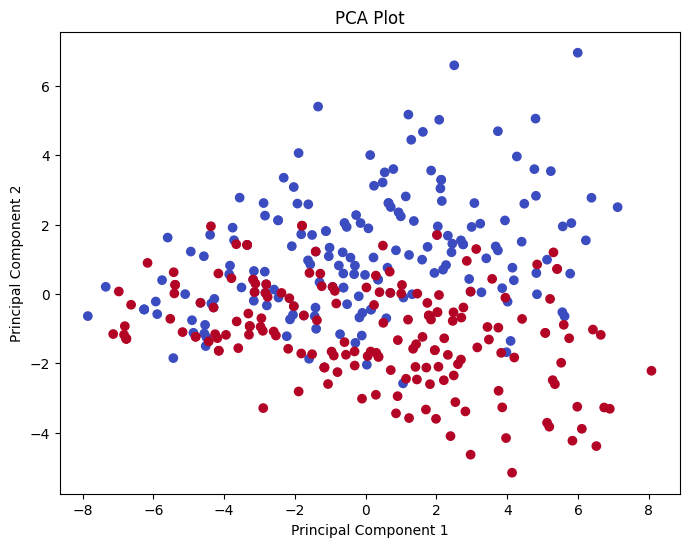

In [12]:
master_sequence = generate_master_sequence(alphabet_size=4, seq_length=150, start_char=68)
n_instances = 200
n_outliers = n_instances//9
n_inliners = n_instances - n_outliers
seqs, targets = make_data(
    master_sequence, 
    n_clusters=2,
    cluster_centres_noise=.5,
    n_inliners=n_inliners, 
    n_outliers=0, 
    inliner_noise=.15, 
    outlier_noise=.99, 
    endpoint_trim_dim=15)

X = histogram_vectorizer(seqs)
pca_plot(X, y=targets)

## Adaptive Boosting (AdaBoost) and Random Forest Classification

In [13]:
from sklearn.tree import DecisionTreeClassifier

def train_ab(X_train, y_train, param):
    #setup
    models = []
    weights = np.full(len(X_train), 1/len(X_train))
    #do X epochs
    
    for i in range(100):
        DTC = DecisionTreeClassifier(max_depth=param)
        DTC.fit(X_train, y_train, sample_weight=weights)

        #get predictions and incorrect preds
        preds = DTC.predict(X_train)
        preds_wrong = (preds != y_train)
        error = np.dot(weights, preds_wrong) / sum(weights)
    
        #calculate model weight difference - now alpha
        #diff = 0.5 * np.log((1 - error) / max(error, 1e-10))

        #update weights

        alpha = 0.5 * np.log((1 - error) / max(error, 1e-10))
        weights *= np.exp(-alpha * ((preds != y_train) * 2 - 1))
        weights /= np.sum(weights)


        models.append((DTC, alpha))

    return models


def test_ab(X_test, models):
    pred_labels = np.zeros(len(X_test))
    for dtc, diff in models:
        preds = dtc.predict(X_test)
        pred_labels += diff * preds
    return np.sign(pred_labels)
    #return np.where(np.sign(pred_labels) == 0, -1, 1)
        
    
class AdaBoostClassifier():
    #INIT
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.subtrees = []
        pass

    def fit(self, X, y):
        self.subtrees = train_ab(X, y, self.max_depth)
        

    def predict(self, X):
        return test_ab(X, self.subtrees)







    
def make_bootstrap(data_matrix, targets):
    #ensure data_matrix and targets are numpy arrays
    if not isinstance(data_matrix, np.ndarray):
        data_matrix = np.array(data_matrix)
    if not isinstance(targets, np.ndarray):
        targets = np.array(targets)

    no_samples = len(data_matrix)
    # sample the indexs with replacement to create a bootstrap
    bootstrap_indices = np.random.choice(no_samples, size=no_samples, replace=True)
    a = np.arange(no_samples)
    oob_indices = np.setdiff1d(a, bootstrap_indices)

    # create the bootstrap
    bootstrap_dm = data_matrix[bootstrap_indices]
    # create the targets
    bootstrap_t = targets[bootstrap_indices]
    #create the oob samples (out of bag)
    oob_data_matrix = data_matrix[oob_indices]
    #create the oob targets
    oob_targets = targets[oob_indices]

    return bootstrap_dm, bootstrap_t, bootstrap_indices, oob_data_matrix, oob_targets, oob_indices
    

def train_rfc(X_train, y_train, param):
    if -1 in y_train:
        y_train = np.where(y_train == -1, 0, 1)
    trees = []
    #iterate X times / epochs
    for i in range(100):
        #get bootstrap sample
        X, y, _, _, _, _ = make_bootstrap(X_train, y_train)
        #train decision tree
        tree = DecisionTreeClassifier(max_depth=param)
        tree.fit(X, y)
        trees.append(tree)
    return trees


def test_rfc(X_test, models):
    #predictions from each tree
    predictions = np.array([tree.predict(X_test) for tree in models])
    #coutn votes
    vote_count = np.zeros((len(X_test), np.max(predictions) + 1), dtype=int)
    for model in models:
        preds = model.predict(X_test)
        for idx, pred in enumerate(preds):
            vote_count[idx, pred] += 1
    predicted_labels = np.argmax(vote_count, axis=1)
    return np.where(np.sign(predicted_labels) == 0, -1, 1)
    #return predicted_labels


class RandomForestClassifier():
    def __init__(self, max_depth=1):
        self.max_depth = max_depth
        self.models = []

    def fit(self, X, y):
        self.models = train_rfc(X, y, self.max_depth)

    def predict(self, X):
        return test_rfc(X, self.models)


#---------------------------------------------------------------------------------------------------------
def evaluate_predictions(labels, predicted):
    # Convert inputs to numpy arrays to ensure compatibility with numpy operations
    labels = np.array(labels)
    predicted = np.array(predicted)

    # Calculate the number of correct predictions
    correct = np.sum(labels == predicted)

    # Calculate the number of incorrect predictions
    incorrect = np.sum(labels != predicted)

    return correct, incorrect
#---------------------------------------------------------------------------------------------------------


'''ABC = AdaBoostClassifier(max_depth=3)	
ABC.fit(X, targets)	
print(ABC.subtrees)	
labs = ABC.predict(X)	
print(f"labs is {labs}")	
targets[targets == 0] = -1	
print(f"targets is {targets}")		
correct, incorrect = evaluate_predictions(targets, labs)		
print(f"correct: {correct}, incorrect: {incorrect}")		

RFC = RandomForestClassifier(max_depth=3)	
RFC.fit(X, targets)	
labs = RFC.predict(X)	
print(f"labs2 is {labs}")	
correct, incorrect = evaluate_predictions(targets, labs)	
print(f"correct: {correct}, incorrect: {incorrect}")	
'''
save_history()

## One-vs-One (OvO) Classification

In [20]:
import copy 

def train_OvO(X_train, y_train, estimator):
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    #extract unique classes
    unique_classes = np.unique(y_train)
    estimators = {}
    #iterate through the uniue classes
    for i in range(len(unique_classes)):
        for j in range(i+1, len(unique_classes)):  
            #print(f"unique classes: {unique_classes[i]}, {unique_classes[j]}")
            class1 = unique_classes[i]
            class2 = unique_classes[j]

            #get the data for the two classes
            index = np.where((y_train == class1) | (y_train == class2))[0].tolist()
            X_t_sub = X_train[index]
            y_t_sub = y_train[index]

            y_t_sub = np.where(y_t_sub == class1, 1, -1)
             #copy the estimator
            estimator_copy = copy.deepcopy(estimator)

            #train one of the models
            estimator_copy.fit(X_t_sub, y_t_sub)

            #append the estimator to the dict
            estimators[(class1, class2)] = estimator_copy
    
    return estimators




def train_OvO_orig(X_train, y_train, estimator):
    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    #extract unique classes
    unique_classes = np.unique(y_train)
    estimators = {}
    #iterate through the uniue classes
    for i in range(len(unique_classes)):
        for j in range(i+1, len(unique_classes)):  
            #print(f"unique classes: {unique_classes[i]}, {unique_classes[j]}")
            class1 = unique_classes[i]
            class2 = unique_classes[j]

            #get the data for the two classes
            index = np.where((y_train == class1) | (y_train == class2))[0].tolist()
            X_t_sub = X_train[index]
            y_t_sub = y_train[index]

             #copy the estimator
            estimator_copy = copy.deepcopy(estimator)

            #train one of the models
            estimator_copy.fit(X_t_sub, y_t_sub)

            #append the estimator to the dict
            estimators[(class1, class2)] = estimator_copy
    
    return estimators
    
    
def test_OvO(X_test, estimators):
    votes = []
    #iterate through each classifier
    for (class1, class2), model in estimators.items():
        #make prediction
        preds = model.predict(X_test)
        class_votes = []
        for pred in preds:
            #store prediction
            if pred == 1:
                class_votes.append(class1)
            else:
                class_votes.append(class2)
            #add to dataset
            votes.append(class_votes)
    #convert to numpy array and transpose to get votes by sample
    votes = np.array(votes).T
    #extrqct voting info
    preds = [np.bincount(sample_votes).argmax() for sample_votes in votes]
    #print(f"OVO preds: {preds}")
    return preds

    
    
class OVOClassifier():

    def __init__(self, estimator):
        self.estimator = estimator
        self.estimators = None


    def fit(self, X, y):
        self.estimators = train_OvO(X, y, self.estimator)


    def predict(self, X):
        return test_OvO(X, self.estimators)




save_history()


## Learning Curve Analysis

In [24]:
from sklearn.model_selection import train_test_split

def compute_learning_curve(estimator, X, y, test_size, n_steps, n_repetitions):
    if 0 in y:
        y[y==0] = -1
    #split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    #data stucts 4 results
    train_errors = []
    test_errors = []
    
    #get training set sizes
    max_train_size = len(X_train)
    min_train_size = max_train_size // 10
    train_sizes = np.linspace(min_train_size, max_train_size, n_steps, dtype=int)


    #iterate through the training sizes
    for size in train_sizes:
        current_train_errors = []
        current_test_errors = []
        # for the specificed number of iterations
        for i in range(n_repetitions):
            #extract a sample from the overall set, 'size' times
            indices = np.random.choice(len(X_train), size, replace=False)
            X_train_subset = X_train[indices]
            y_train_subset = y_train[indices]

            #train the model
            
            estimator.fit(X_train_subset, y_train_subset)

            # Calculate errors
            train_error = evaluate_predictions_with_model(estimator, X_train_subset, y_train_subset)
            test_error = evaluate_predictions_with_model(estimator, X_test, y_test)

            #add errors to the current list
            current_train_errors.append(train_error)
            current_test_errors.append(test_error)
        # Record the mean errors
        train_errors.append(np.mean(current_train_errors))
        test_errors.append(np.mean(current_test_errors))
    return train_sizes, train_errors, test_errors



def evaluate_predictions_with_model(model, X, labels):
    # Ensure that labels are a numpy array for compatibility with numpy operations
    labels = np.array(labels)
    
    # Use the model to make predictions on the feature matrix X
    predicted = model.predict(X)
    
    # Calculate the number of correct predictions
    correct = np.sum(labels == predicted)
    
    # Calculate the number of incorrect predictions
    incorrect = np.sum(labels != predicted)

    
    return incorrect/(correct+incorrect)


    
    
def plot_learning_curve(sizes, train_errors, test_errors):
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, test_errors, label='Test error')
    plt.plot(sizes, train_errors, label='Training error', color='orange', linestyle='dotted')
    plt.ylim(0, 1)
    plt.xlabel('Size of training set')
    plt.ylabel('Error')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid()
    plt.show()
    


'''RFC = RandomForestClassifier(max_depth=3)
ADA = AdaBoostClassifier(max_depth=3)
print(targets)
targets[targets == 0] = -1
x,y,z = compute_learning_curve(ADA, X, targets, 0.3, 5, 10)
print(x)
print(y)
print(z)


plot_learning_curve(x, y, z)
'''



save_history()

## Sequence Kernel Methods and Multidimensional Scaling (MDS)

In [27]:

from sklearn.manifold import MDS

def histogram_kernel(seq_1, seq_2, param=None):
    #get dicts of unique chars with counts
    unique_chars_1 = {char: seq_1.count(char) for char in seq_1}
    unique_chars_2 = {char: seq_2.count(char) for char in seq_2}

    #get the intersection of the two dicts with count
    intersection = {}
    for char1 in unique_chars_1:
        for char2 in unique_chars_2:
            if char1 == char2:
                intersection[char1] = min(unique_chars_1[char1], unique_chars_2[char2])

    #get the union of the two dicts with count
    union = {}
    for char1 in unique_chars_1:
        union[char1] = max(unique_chars_1[char1], unique_chars_2.get(char1, 0))
    for char2 in unique_chars_2:
        if char2 not in union:
            union[char2] = unique_chars_2[char2]

    #calculate the kernel -  AnB.count / AuB.count
    kernel = sum(intersection.values()) / sum(union.values())

    return kernel


def histogram_kernel_dep(seq_1, seq_2, param=None):
    #convert arrays to unique elements and their counts
    unique_1, counts_1 = np.unique(seq_1, return_counts=True)
    unique_2, counts_2 = np.unique(seq_2, return_counts=True)

    #create dictionaries from unique values to counts
    dict_1 = dict(zip(unique_1, counts_1))
    dict_2 = dict(zip(unique_2, counts_2))

    intersection = 0
    union = 0

    #get interesrection and union
    all_keys = set(dict_1.keys()).union(dict_2.keys())
    for key in all_keys:
        if key in dict_1 and key in dict_2:
            intersection += min(dict_1[key], dict_2[key])
            union += max(dict_1[key], dict_2[key])
        elif key in dict_1:
            union += dict_1[key]
        elif key in dict_2:
            union += dict_2[key]


    #calculate the kernel
    if union == 0:
        return 0
    else:
        return intersection / union
    


def kmer_kernel(seq_1, seq_2, param=None):
    #generate k as small compared to the sequence
    k0 = int(min(len(seq_1), len(seq_2))/10)+1
    k = param if param is not None else (k0 if k0 > 1 else 2)
    #make k-mers from a sequence
    def generate_kmers(seq, k):
        return [seq[i:i+k] for i in range(len(seq) - k + 1)]

    def counter(items):
        counts = {}
        for item in items:
            if item in counts:
                counts[item] += 1
            else:
                counts[item] = 1
        return counts
    
    #get the kmers
    kmer_1 = generate_kmers(seq_1, k)
    kmer_2 = generate_kmers(seq_2, k)

    #get the counts of the k-mers
    counts_1 = counter(kmer_1)
    counts_2 = counter(kmer_2)

    #do the dot product and nroms
    all_kmers = set(counts_1.keys()).union(set(counts_2.keys()))
    dot_product = sum(counts_1.get(k, 0) * counts_2.get(k, 0) for k in all_kmers)
    norm_1 = np.sqrt(sum(val ** 2 for val in counts_1.values()))
    norm_2 = np.sqrt(sum(val ** 2 for val in counts_2.values()))

    #Calculate the kernel
    if norm_1 == 0 or norm_2 == 0:
        return 0
    else:
        return dot_product / (norm_1 * norm_2)


def get_gram_matrix(seqs, kernel_func, param):
    #create empty matrix
    num_seqs = len(seqs)
    gram_matrix = np.zeros((num_seqs, num_seqs)) 

    #calc kernel for each pair of sequences
    for i in range(num_seqs):
        for j in range(i, num_seqs):
            kernel_value = kernel_func(seqs[i], seqs[j], param)
            gram_matrix[i, j] = kernel_value
            gram_matrix[j, i] = kernel_value  # Symmetric filling
    
    return gram_matrix


def gram_matrix_to_distance_matrix(G):
    #transfrom
    D = 1 - G
    # Ensure diagonal elements are zero since the distance to oneself is zero
    np.fill_diagonal(D, 0)
    
    return D


def mds_plot(seqs, y=None, kernel_func=None, param=None):
    #get gram matrix
    g = get_gram_matrix(seqs, kernel_func, param)
    #get distance matrix
    d = gram_matrix_to_distance_matrix(g)
    #Use MDS
    mds = MDS(n_components=2, dissimilarity = "precomputed")
    mds_points = mds.fit_transform(d)

    #plot
    plt.figure(figsize=(10, 6))
    if y is not None:
        scatter = plt.scatter(mds_points[:, 0], mds_points[:, 1], c=y, cmap='coolwarm')
    else:
        scatter = plt.scatter(mds_points[:, 0], mds_points[:, 1], color='blue') 
    plt.title('MDS Plot of Sequences')
    plt.xlabel('MDS Dimension 1')
    plt.ylabel('MDS Dimension 2')
    plt.grid()
    plt.show()
    
'''#, [28, 39, 34, 33], [25, 39, 36, 35]
x1 = np.array([27, 30, 36, 32])
#, [29, 36, 35, 33], [27, 35, 36, 35]
x2 = np.array([30, 36, 36, 36])

print(histogram_kernel(x1, x2))'''


save_history()

## Test

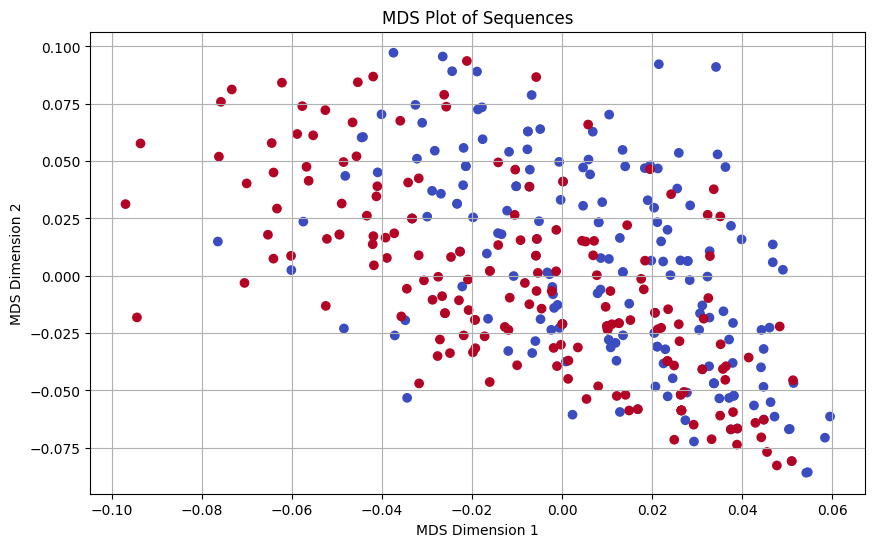

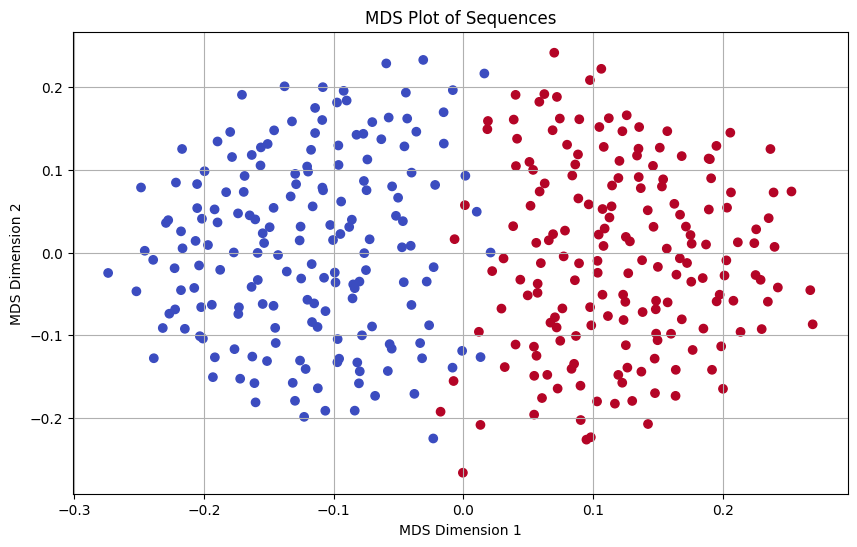

In [33]:
master_sequence = generate_master_sequence(alphabet_size=4, seq_length=150, start_char=68)
n_instances = 200
n_outliers = n_instances//9
n_inliners = n_instances - n_outliers
seqs, targets = make_data(
    master_sequence, 
    n_clusters=2,
    cluster_centres_noise=.5,
    n_inliners=n_inliners, 
    n_outliers=0, 
    inliner_noise=.15, 
    outlier_noise=.99, 
    endpoint_trim_dim=15)

mds_plot(seqs, y=targets, kernel_func=histogram_kernel, param=None)

mds_plot(seqs, y=targets, kernel_func=kmer_kernel, param=3)

## Kernelized Large Margin Classifiers


### Linear case

We need to match the solver's API which, according to the documentation is of the form:

\begin{aligned}
    & \min \frac{1}{2} x^TPx + q^Tx
    \\
     s.t. \ & \ Gx \leq h 
    \\
    & \ Ax = b
\end{aligned}

Recall that the dual problem is expressed as:

\begin{aligned}
\max_{\alpha} \sum_i^m \alpha_i - \frac{1}{2} \sum_{i,j}^m y^{(i)}y^{(j)} \alpha_i \alpha_j <x^{(i)}, x^{(j)}>
\end{aligned}

Let $\mathbf{H}$ be a matrix such that $H_{i,j} = y^{(i)}y^{(j)} <x^{(i)} x^{(j)}>$, then the optimization becomes:

\begin{aligned}
    & \max_{\alpha} \sum_i^m \alpha_i  - \frac{1}{2}  \alpha^T \mathbf{H}  \alpha
    \\
     s.t. & \ \alpha_i \geq 0 
    \\
    &  \ \sum_i^m \alpha_i y^{(i)} = 0  
\end{aligned}

We convert the sums into vector form and multiply both the objective and the constraint by −1 which turns this into a minimization problem and reverses the inequality

\begin{aligned}
    & \min_{\alpha}  \frac{1}{2}  \alpha^T \mathbf{H}  \alpha - 1^T \alpha
    \\
    & s.t. \ - \alpha_i \leq 0 
    \\
    & s.t. \ y^T \alpha = 0 
\end{aligned}

We are now ready to convert our numpy arrays into the cvxopt format, using the same notation as in the documentation this gives

* $P:=H$ a matrix of size $m×m$
* $q:=−\vec{1}$  a vector of size $m×1$
* $G:=−diag[1]$ a diagonal matrix of -1s of size $m×m$
* $h:=\vec{0}$ a vector of zeros of size $m×1$
* $A:=y^T$ the label vector of size $1×m$
* $b:=0$ a scalar

Note that in the simple example of $m=2$ the matrix $G$ and vector $h$ which define the constraint are 

$$G = \begin{bmatrix} -1 & 0 \\ 0 & -1 \end{bmatrix} \ \ \text{and} \ \ h = \begin{bmatrix} 0 \\ 0  \end{bmatrix}$$

### Computing the matrix $\mathbf{H}$ in vectorized form

Consider the simple example with 2 input samples $\{x^{(1)}, x^{(2)}\} \in \mathbb{R}^2$ which are two dimensional vectors. i.e. $x^{(1)} = (x_1^{(1)} , x_2^{(1)})^T$

$$X = \begin{bmatrix} x_1^{(1)} & x_2^{(1)} \\ x_1^{(2)} & x_2^{(2)} \end{bmatrix} \ \ \text{and} \ \ y = \begin{bmatrix} y^{(1)}  \\ y^{(2)} \end{bmatrix}$$

We now proceed to creating a new matrix $X′$ where each input sample $x$ is multiplied by the corresponding output label y. This can be done easily in Numpy using vectorization and padding.

$$X' = \begin{bmatrix} x^{(1)}_1 y^{(1)} & x^{(1)}_2y^{(1)} \\
x^{(2)}_1y^{(2)} & x^{(2)}_2y^{(2)} \end{bmatrix}$$

Finally we take the **matrix multiplication** of $X′$ and its transpose giving $H=X′X′^T$

$$H = X' @ X'^T = \begin{bmatrix} x^{(1)}_1 y^{(1)} & x^{(1)}_2y^{(1)} \\
x^{(2)}_1y^{(2)} & x^{(2)}_2y^{(2)} \end{bmatrix} \begin{bmatrix} x^{(1)}_1 y^{(1)} & x^{(2)}_1 y^{(2)}  \\
x^{(1)}_2y^{(1)} & x^{(2)}_2y^{(2)} \end{bmatrix}$$

$$H = \begin{bmatrix}  x^{(1)}_1 x^{(1)}_1y^{(1)}y^{(1)} + x^{(1)}_2x^{(1)}_2y^{(1)}y^{(1)} & x^{(1)}_1 x^{(2)}_1y^{(1)}y^{(2)} + x^{(1)}_2x^{(2)}_2y^{(1)}y^{(2)} \\ x^{(2)}_1 x^{(1)}_1y^{(2)}y^{(1)} + x^{(2)}_2x^{(1)}_2y^{(2)}y^{(1)} & x^{(2)}_1 x^{(2)}_1y^{(2)}y^{(2)} + x^{(2)}_2x^{(2)}_2y^{(2)}y^{(2)} \end{bmatrix}$$


### Soft margin
For the softmax margin SVM, recall that the optimization problem can be expressed as

\begin{aligned}
    & \max_{\alpha} \sum_i^m \alpha_i  - \frac{1}{2}  \alpha^T \mathbf{H}  \alpha
    \\
     s.t. \ \ & 0 \leq \alpha_i \leq C 
    \\
    &  \ \sum_i^m \alpha_i y^{(i)} = 0  
\end{aligned}

which can be written in standard form as

\begin{aligned}
    & \min_{\alpha}  \frac{1}{2}  \alpha^T \mathbf{H}  \alpha - 1^T \alpha
    \\
     s.t. & \ - \alpha_i \leq 0 
    \\
     & \alpha_i \leq C
     \\
     &\ y^T \alpha = 0  
\end{aligned}

This is almost the same problem as previously, except for the additional inequality constraint on $\alpha$. We translate this new constraint into standard form by concatenating below matrix $G$ a diagonal matrix of 1s of size $m \times m$. Similarly for the vector $h$ to which the value of $C$ is added $m$ times.

Note that in the simple example of $m=2$ the matrix $G$ and vector $h$ which define the constraint are

$$G = \begin{bmatrix} -1 & 0 \\ 0 & -1 \\ 1 & 0 \\ 0 & 1\end{bmatrix} \ \ \text{and} \ \ h = \begin{bmatrix} 0 \\ 0 \\ C \\ C \end{bmatrix}$$


### Non linear case

What has been written above corresponds to the hard and the soft margin case for a linear large margin classification problem.  

You now need to appy the *kernel trick*, i.e. you need to replace the dot product operations in the input space $<x^{(i)} x^{(j)}>$ with the dot product in the feature space via a kernel function $K(x^{(i)},x^{(j)}) = <\phi(x^{(i)}) \phi(x^{(j)})>$. 

## Soft Large Margin Kernel Classifier



In [34]:
from cvxopt import matrix
from cvxopt import solvers
import pandas as pd

def ensure_numpy_array(array_like):
    if isinstance(array_like, (pd.DataFrame, pd.Series, list)):
        return np.array(array_like)
    return array_like


def make_H_k(X,t, kernel_function, param):
    #ensure datatypes
    X = ensure_numpy_array(X)
    t = ensure_numpy_array(t)
    #initialise the gram matrix
    H = np.zeros((len(X), len(X)))
    #fill the gram martix
    for i in range(len(X)):
        for j in range(i,len(X)):
            #apply kernel functipon to a pair
            kernel_val = kernel_function(X[i], X[j], param)
            #print(f"kernel_val is {kernel_val}, t[i] is {t[i]}, t[j] is {t[j]}")
            # the *t[i] * t[j] considers the labels polarity
            H[i, j] = kernel_val * t[i] * t[j]
            H[j, i] = H[i, j]
    return H

    
def setup_optimization_soft_k(X,t,C, kernel_function, param):
    #ensure datatypes
    X = ensure_numpy_array(X)
    t = ensure_numpy_array(t)
   #get intial matrix and params
    m = len(X)
    H = make_H_k(X, t, kernel_function, param)
    #transform to cvx matrices
    P = matrix(H)
    q = matrix(-np.ones((m, 1)))
    # maybe should have positive identity matrix underneath
    G = matrix(np.vstack((np.eye(m) * -1, np.eye(m))))
    # specifies upper bounds of G
    h = matrix(np.vstack((np.zeros((m, 1)), np.ones((m, 1)) * C)))
    #reshape targets
    A = matrix(t.reshape(1, -1), tc='d')
    b = matrix(np.zeros(1))

    return P, q, G, h, A, b

    
def compute_support_vectors(X,t,alphas):
     #ensure datatypes
    X = ensure_numpy_array(X)
    t = ensure_numpy_array(t)
    #reshape targets and extract values above alpha
    alphas = np.array(alphas).flatten()
    t = t.reshape(-1, 1).astype(float)
    support_ids = (alphas > 1e-4).flatten()
    #Extract support vectors and their properties
    support_vectors = X[support_ids]
    support_targets = t[support_ids]
    support_alphas = alphas[support_ids]
    
    return support_vectors, support_targets, support_alphas, support_ids, alphas




def train_slmkc(X, t, C, kernel_function, param):
    #ensure datatypes
    X = ensure_numpy_array(X)
    t = ensure_numpy_array(t)
    #setup optimisation
    P, q, G, h, A, b = setup_optimization_soft_k(X, t, C, kernel_function, param)
    #set solver params and problem
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(solution['x']).flatten()
    #get support vectors
    support_vectors, support_targets, support_alphas, support_ids, _ = compute_support_vectors(X, t, alphas)

    return (support_vectors, support_targets, support_alphas, support_ids)



def compute_bias(kernel_function, param, C, model):
    #extract the parts of the model
    #print("IN COMPUTE BIAS ")
    support_vectors, support_targets, support_alphas, support_ids = model
    sv_count = support_vectors.shape[0]
    bias_sum = 0
    for i in range(sv_count):
        bias_sum += support_targets[i]
        for j in range(sv_count):
            bias_sum -= support_alphas[j] * support_targets[j] * kernel_function(support_vectors[j], support_vectors[i], param)
    bias = bias_sum / sv_count
    #print(f"bias is {bias}")
    return bias



def compute_bias_dep(kernel_function, param, C, model):
    #extract the parts of the model
    #print("IN COMPUTE BIAS ")
    support_vectors, support_targets, support_alphas, support_ids = model
    
    #get the support vectors on the marhgin, make sure they are bound by C
    margin = (support_alphas > 0) & (support_alphas < C)
    

    #extract bias from the support vectors of the index of the first suitable support vector
    support_index = margin.nonzero()[0][0] 
    x_n = support_vectors[support_index]
    t_n = support_targets[support_index]
    
    #return averaged bias fgrom the support vectors
    b = t_n - sum(
        support_alphas[i] * support_targets[i] * kernel_function(support_vectors[i], x_n, param)
        for i in range(len(support_vectors))
    )
    #print(f"b is {b}")

    return b

    
def score_slmkc(X_test, kernel_function, param, C, model):
    #Extract model data
    support_vectors, support_targets, support_alphas, support_ids = model
    # get bias
    bias = compute_bias(kernel_function, param, C, model)
    scores = []
    # for each X_test
    for x in X_test:
        s = sum(support_alphas[i] * support_targets[i] * kernel_function(support_vectors[i], x, param) for i in range(len(support_vectors))) + bias
        scores.append(s)

    return np.array(scores)

    

def test_slmkc(X_test, kernel_function, param, C, model):
    preds = np.sign(score_slmkc(X_test, kernel_function, param, C, model))
    return preds.flatten()
    


class SoftLargeMarginKernelClassifier(object):
    def __init__(self, C, kernel_function, param):
        self.C = C
        self.kernel_function = kernel_function
        self.param = param
        self.support_vectors = None
        self.support_targets = None
        self.support_alphas = None
        self.support_ids = None

    def fit(self, X, y):
        self.support_vectors, self.support_targets, self.support_alphas, self.support_ids = train_slmkc(X, y, self.C, self.kernel_function, self.param)

    def predict(self, X):
        return test_slmkc(X, self.kernel_function, self.param, self.C, (self.support_vectors, self.support_targets, self.support_alphas, self.support_ids))
    
    def decision_function(self, X):
        scores = score_slmkc(X, self.kernel_function, self.param, self.C, (self.support_vectors, self.support_targets, self.support_alphas, self.support_ids))
        return np.sign(scores)

    def predict_proba(self, X):
        scores = score_slmkc(X, self.kernel_function, self.param, self.C, (self.support_vectors, self.support_targets, self.support_alphas, self.support_ids))
        probs = 1 / (1 + np.exp(-scores))
        return probs









'''
ts = np.array([target if target == 1 else -1 for target in targets])

#H = make_H_k(seqs, ts, kmer_kernel, None)

#P, q, G, h, A, b = setup_optimization_soft_k(seqs, ts, 1, kmer_kernel, 3)

alphas = np.zeros(len(seqs))
alphas[5] = 1

seqs_train, seqs_test = seqs[:-10], seqs[-10:]
ts_train, ts_test = ts[:-10], ts[-10:]

#print(f"seqs_train is \n{seqs_train}\nseqs_test is \n{seqs_test}")

SLMKC = SoftLargeMarginKernelClassifier(1e0, kmer_kernel, 3)
SLMKC.fit(seqs_train, ts_train)
preds = SLMKC.predict(seqs_test)
print(f"preds is {preds}, \norig is {ts_test}")

probas = SLMKC.decision_function(seqs_test)

print(probas)'''



    
save_history()

## 2D Sequence Plotting

In [45]:
from sklearn.manifold import MDS
import matplotlib.colors as mcolors

def plot_seq_2d(seqs, y=None, preds=None, is_support=None, kernel_func=None, param=None):
    gram_matrix = get_gram_matrix(seqs, kernel_func, param)
    distance_matrix = gram_matrix_to_distance_matrix(gram_matrix)
    

    #apply MDS to the distance matrix
    mds = MDS(n_components=2, dissimilarity="precomputed")
    coords = mds.fit_transform(distance_matrix)

    title_content = f'{len(seqs)} instances'

    #plotting
    plt.figure(figsize=(10, 8))
    #make colour map
    cmap = plt.get_cmap('coolwarm')
    norm = mcolors.Normalize(vmin=-1, vmax=1)
    #make support mask
    
    if is_support is not None:
        support_mask = np.array(is_support)
        non_support_mask = ~support_mask

        # plot non-support vectors
        plt.scatter(coords[non_support_mask, 0], coords[non_support_mask, 1], c=cmap(norm(y[non_support_mask])), alpha=0.75, s = 80, label='Non-Support Vectors')

        #plot support vectors
        support_coords = coords[support_mask]
        support_labels = y[support_mask]
        
        colors = cmap(norm(support_labels))
        plt.scatter(support_coords[:, 0], support_coords[:, 1], c=cmap(norm(y[support_mask])), edgecolors='black', alpha=1, s=50)

        #amend title
        title_content += f"{len(is_support[is_support == True])} support vec [{len(is_support[is_support ==True])/len(seqs):.2f} perc] "
    else:
        #if no support vector info
        plt.scatter(coords[:, 0], coords[:, 1], c=cmap(norm(y)), alpha=0.5)


    if y is not None:
        if preds is not None:
            misclassified = y != preds
            correctly_classified = ~misclassified

            cmap = plt.get_cmap('coolwarm')
            # Plot correctly classified points
            #plt.scatter(coords[correctly_classified, 0], coords[correctly_classified, 1], c=cmap(norm(y[correctly_classified])), s=80, alpha=0.75)

            # Highlight misclassifications with x markers
            plt.scatter(coords[misclassified, 0], coords[misclassified, 1], c=cmap(norm(y[misclassified])), marker='X', s=100, edgecolors="black")

            # Calculate number of mistakes and the accuracy
            no_of_mistakes = np.sum(misclassified)
            accuracy = 100 * (1 - no_of_mistakes / len(y))
            title_content += f"{no_of_mistakes} mistakes [{accuracy:.2f} perc]"
        

    plt.xlabel('MDS Dimension 1')
    plt.ylabel('MDS Dimension 2')
    plt.title(title_content)
    plt.show()

'''
plot_seq_2d(seqs, y=targets, kernel_func=kmer_kernel, param=3)
'''
save_history()

## Test

     pcost       dcost       gap    pres   dres
 0: -4.1169e+01 -3.5754e+02  1e+03  2e+00  7e-16
 1: -2.7502e+01 -1.9532e+02  2e+02  7e-02  6e-16
 2: -3.4133e+01 -6.0634e+01  3e+01  9e-03  7e-16
 3: -3.9638e+01 -4.7484e+01  8e+00  2e-03  5e-16
 4: -4.1667e+01 -4.3810e+01  2e+00  4e-04  5e-16
 5: -4.2358e+01 -4.2704e+01  3e-01  2e-15  5e-16
 6: -4.2492e+01 -4.2505e+01  1e-02  4e-16  5e-16
 7: -4.2497e+01 -4.2497e+01  4e-04  4e-16  5e-16
 8: -4.2497e+01 -4.2497e+01  8e-06  9e-16  5e-16
Optimal solution found.


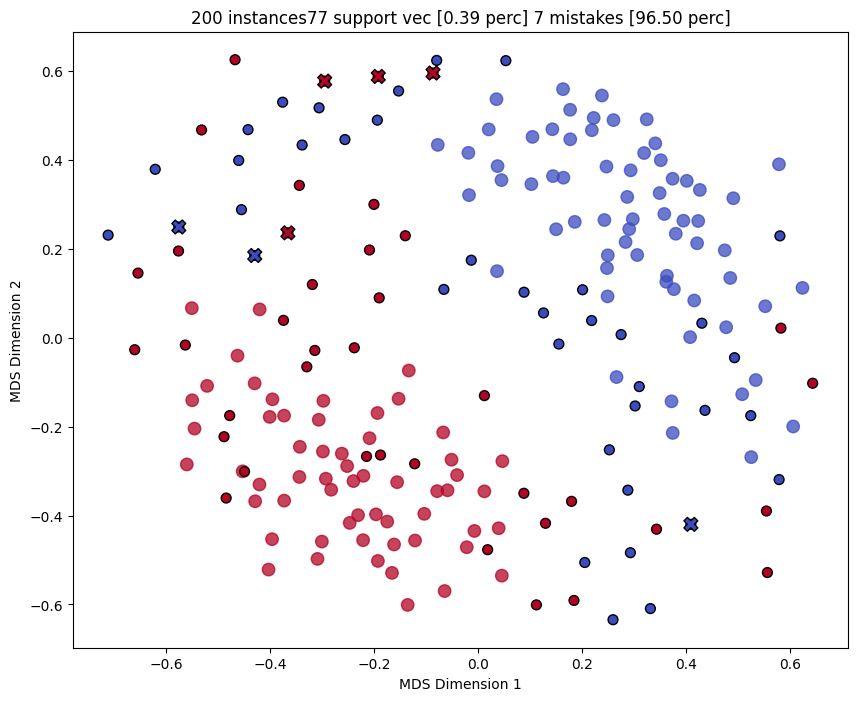

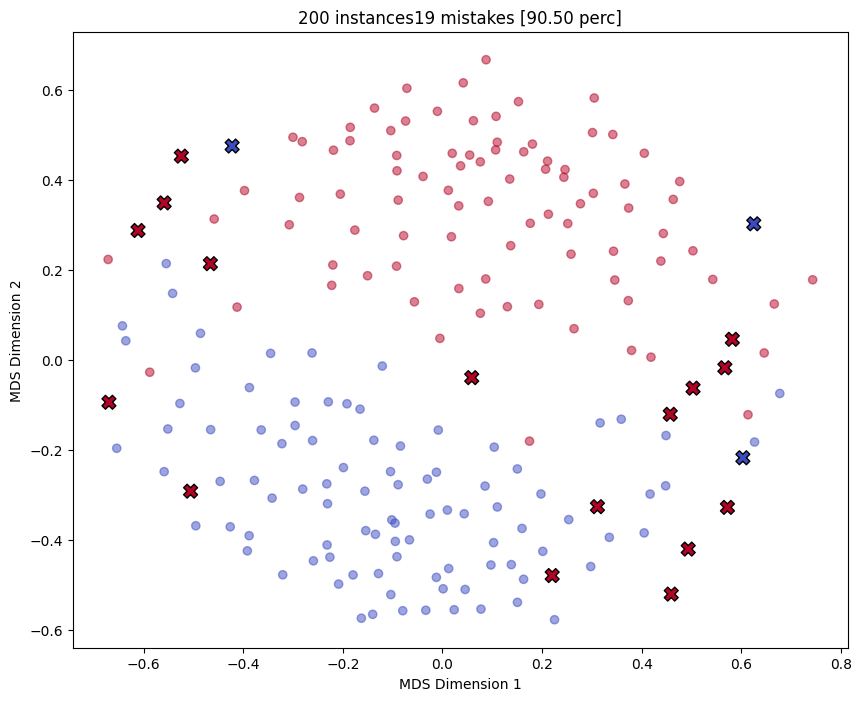

In [47]:
master_sequence = generate_master_sequence(alphabet_size=5, seq_length=30, start_char=68)
n_instances = 200
n_outliers = n_instances//5
n_inliners = n_instances - n_outliers
seqs, targets = make_data(
    master_sequence, 
    n_clusters=2,
    cluster_centres_noise=.3,
    n_inliners=n_inliners, 
    n_outliers=n_outliers, 
    inliner_noise=.15, 
    outlier_noise=.99, 
    endpoint_trim_dim=5)

param = 3
y = np.array(targets)
y[y==0]=-1

from sklearn.model_selection import train_test_split
train_seqs, test_seqs, train_y, test_y = train_test_split(seqs,y, train_size=.5)

est = SoftLargeMarginKernelClassifier(C=1e0, kernel_function=kmer_kernel, param=param)
est.fit(train_seqs, train_y)

preds = est.predict(train_seqs)
plot_seq_2d(train_seqs, y=train_y, preds=preds, is_support=est.support_ids, kernel_func=kmer_kernel, param=param)

preds = est.predict(test_seqs)
plot_seq_2d(test_seqs, y=test_y, preds=preds, kernel_func=kmer_kernel, param=param)

## Test


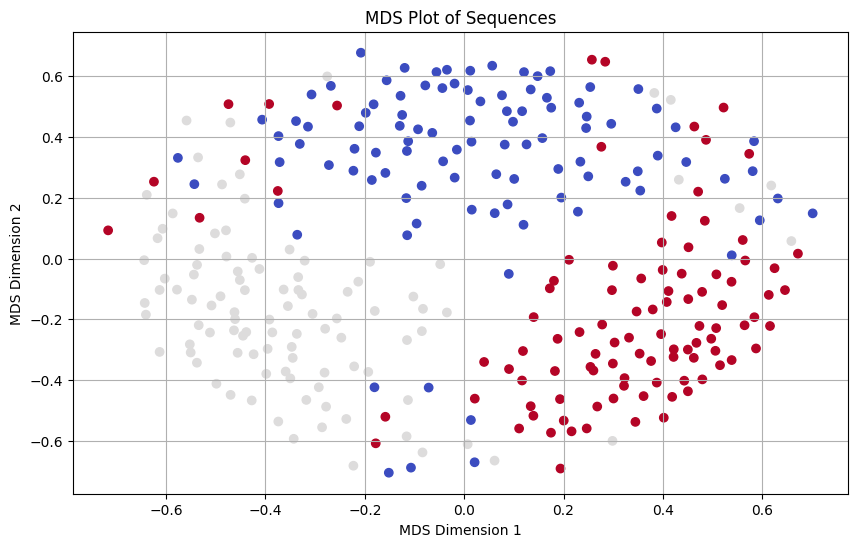

     pcost       dcost       gap    pres   dres
 0: -3.3620e+01 -2.4931e+02  9e+02  2e+00  6e-16
 1: -2.3868e+01 -1.3810e+02  1e+02  1e-02  5e-16
 2: -3.0335e+01 -4.7342e+01  2e+01  2e-03  4e-16
 3: -3.4140e+01 -3.8717e+01  5e+00  3e-04  4e-16
 4: -3.5502e+01 -3.6282e+01  8e-01  3e-05  4e-16
 5: -3.5759e+01 -3.5858e+01  1e-01  3e-06  5e-16
 6: -3.5797e+01 -3.5800e+01  4e-03  7e-08  4e-16
 7: -3.5798e+01 -3.5798e+01  2e-04  2e-09  5e-16
 8: -3.5798e+01 -3.5798e+01  5e-06  4e-11  5e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.6035e+01 -2.5821e+02  9e+02  2e+00  7e-16
 1: -2.6048e+01 -1.4813e+02  1e+02  2e-02  5e-16
 2: -3.2202e+01 -5.1714e+01  2e+01  3e-03  4e-16
 3: -3.6675e+01 -4.0941e+01  4e+00  5e-04  5e-16
 4: -3.8029e+01 -3.8688e+01  7e-01  4e-05  4e-16
 5: -3.8269e+01 -3.8308e+01  4e-02  1e-06  4e-16
 6: -3.8285e+01 -3.8287e+01  2e-03  4e-08  4e-16
 7: -3.8285e+01 -3.8286e+01  7e-05  5e-10  5e-16
 8: -3.8285e+01 -3.8285e+01  3e-06  5e-12  4e-1

In [48]:
master_sequence = generate_master_sequence(alphabet_size=5, seq_length=30, start_char=68)
n_instances = 100
n_outliers = n_instances//5
n_inliners = n_instances - n_outliers
seqs, targets = make_data(
    master_sequence, 
    n_clusters=3,
    cluster_centres_noise=.3,
    n_inliners=n_inliners, 
    n_outliers=n_outliers, 
    inliner_noise=.15, 
    outlier_noise=.99, 
    endpoint_trim_dim=5)

mds_plot(seqs, y=targets, kernel_func=kmer_kernel, param=3)

seqs_train, seqs_test, targets_train, targets_test = train_test_split(seqs, targets, test_size=0.33, shuffle=True, random_state=0)
estimator = SoftLargeMarginKernelClassifier(C=1e0, kernel_function=kmer_kernel, param=3)
est = OVOClassifier(estimator=estimator)
est.fit(seqs_train, targets_train)
preds = est.predict(seqs_test)
from sklearn.metrics import accuracy_score
acc = accuracy_score(targets_test, preds)
print('Predictive accuracy: %.2f'%acc)

---